In [23]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import shutil
import sqlite3
import matplotlib.pyplot as plt
from matplotlib import colors, cm, pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [24]:
FEATURE_SLICES_DIR = '/Users/darylwilding-mcbride/Downloads/slices'

In [25]:
# font paths for overlay labels
UBUNTU_FONT_PATH = '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf'
MACOS_FONT_PATH = '/Library/Fonts/Arial.ttf'

In [26]:
if os.path.isfile(UBUNTU_FONT_PATH):
    feature_label_font = ImageFont.truetype(UBUNTU_FONT_PATH, 10)
else:
    feature_label_font = ImageFont.truetype(MACOS_FONT_PATH, 10)

In [27]:
# for drawing on tiles
TINT_COLOR = (0, 0, 0)  # Black
OPACITY = int(255 * 0.1)  # lower opacity means more transparent

In [28]:
# image dimensions
PIXELS_X = 1400
PIXELS_Y = 400

In [29]:
def pixel_xy(mz, scan, mz_lower, mz_upper, scan_lower, scan_upper):
    x_pixels_per_mz = (PIXELS_X-1) / (mz_upper - mz_lower)
    y_pixels_per_scan = (PIXELS_Y-1) / (scan_upper - scan_lower)
    
    pixel_x = int((mz - mz_lower) * x_pixels_per_mz)
    pixel_y = int((scan - scan_lower) * y_pixels_per_scan)
    return (pixel_x, pixel_y)

In [30]:
raw_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-precursor-1000-of-52464/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-precursor-1000-cuboid-points-ms1-df.pkl')

In [31]:
# create the colour mapping
colour_map = plt.get_cmap('rainbow')
norm = colors.LogNorm(vmin=raw_df.intensity.min(), vmax=100, clip=True)  # aiming to get good colour variation in the lower range, and clipping everything else

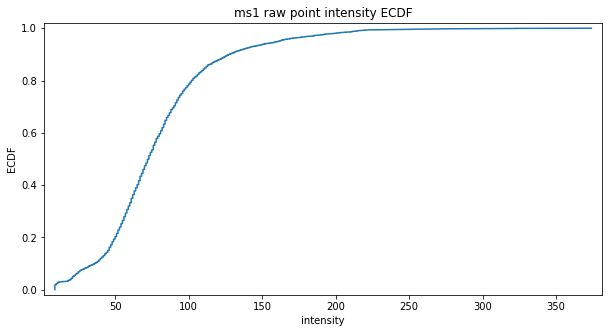

In [32]:
# determine the best clipping value using an ECDF

import statsmodels.api as sm
ecdf = sm.distributions.ECDF(raw_df.intensity)

f, ax1 = plt.subplots()
plt.plot(ecdf.x, ecdf.y)
f.set_figheight(5)
f.set_figwidth(10)
plt.xlabel('intensity')
plt.ylabel('ECDF')
# plt.axvline(x=3000, linestyle=':', linewidth=1, color='orange')
plt.margins(0.02)
plt.title("ms1 raw point intensity ECDF")
plt.show()

In [33]:
# clear out any previous feature slices
if os.path.exists(FEATURE_SLICES_DIR):
    shutil.rmtree(FEATURE_SLICES_DIR)
os.makedirs(FEATURE_SLICES_DIR)

In [34]:
# calculate the raw point coordinates in scaled pixels
pixel_df = pd.DataFrame(raw_df.apply(lambda row: pixel_xy(row.mz, row.scan, raw_df.mz.min(), raw_df.mz.max(), raw_df.scan.min(), raw_df.scan.max()), axis=1).tolist(), columns=['pixel_x','pixel_y'])
raw_pixel_df = pd.concat([raw_df, pixel_df], axis=1)

# sum the intensity of raw points that have been assigned to each pixel
pixel_intensity_df = raw_pixel_df.groupby(by=['frame_id', 'pixel_x', 'pixel_y'], as_index=False).intensity.sum()

In [35]:
# calculate the colour to represent the intensity
colours_l = []
for i in pixel_intensity_df.intensity.unique():
    colours_l.append((i, colour_map(norm(i), bytes=True)[:3]))
colours_df = pd.DataFrame(colours_l, columns=['intensity','colour'])
pixel_intensity_df = pd.merge(pixel_intensity_df, colours_df, how='left', left_on=['intensity'], right_on=['intensity'])

In [36]:
# determine the cuboid dimensions
mz_lower = raw_df.mz.min()
mz_upper = raw_df.mz.max()
scan_lower = raw_df.scan.min()
scan_upper = raw_df.scan.max()
rt_lower = raw_df.retention_time_secs.min()
rt_upper = raw_df.retention_time_secs.max()

x_pixels_per_mz = (PIXELS_X-1) / (mz_upper - mz_lower)
y_pixels_per_scan = (PIXELS_Y-1) / (scan_upper - scan_lower)

In [37]:
pixel_intensity_df.sample(n=3)

,frame_id,pixel_x,pixel_y,intensity,colour
2499,4144,1090,207,50,"(236, 199, 110)"
982,4053,1074,154,73,"(255, 100, 51)"
2084,4123,920,234,45,"(214, 219, 126)"


In [38]:
# write out the images to files
feature_slice = 0
for group_name,group_df in pixel_intensity_df.groupby(['frame_id'], as_index=False):
    # create an intensity array
    tile_im_array = np.zeros([PIXELS_Y, PIXELS_X, 3], dtype=np.uint8)  # container for the image
    tile_im_array[:,:,:] = (30,30,30)
    for r in zip(group_df.pixel_x, group_df.pixel_y, group_df.colour):
        x = r[0]
        y = r[1]
        c = r[2]
        tile_im_array[y:int(y+y_pixels_per_scan),x,:] = c

    # create an image of the intensity array
    feature_slice += 1
    tile = Image.fromarray(tile_im_array, 'RGB')
    draw = ImageDraw.Draw(tile)
    
    # save the image as a file
    tile_file_name = '{}/feature-slice-{:03d}.png'.format(FEATURE_SLICES_DIR, feature_slice)
    tile.save(tile_file_name)